<a href="https://colab.research.google.com/github/hansong0219/Advanced-DeepLearning-Study/blob/master/UNET/ResUNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import os
import sys
from tensorflow.keras.layers import Input, Dropout, Concatenate, add
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2

In [10]:
def res_block(layer_inputs, filters, size, strides=1,BN_ReLU_First=False, shorcut_conv = False):
  initializer = tf.random_normal_initializer(0.,0.02)
  shortcut = layer_inputs

  if BN_ReLU_First:
    x = BatchNormalization()(layer_inputs) 
    x = Activation('relu')(x)
    x = Conv2D(filters, size, strides = strides, padding = 'same', kernel_initializer = initializer)(x)
  else: 
    x = Conv2D(filters, size, strides = strides, padding = 'same', kernel_initializer = initializer)(layer_inputs)

  x = BatchNormalization()(x) 
  x = Activation('relu')(x)
  x = Conv2D(filters,size, strides=1, padding = 'same')(x)
    
  if shorcut_conv:
    shortcut = Conv2D(filters, size, strides = strides, padding='same', kernel_initializer=initializer)(shortcut)

  x = add([x, shortcut])

  return x

def res_block_deep(layer_inputs, filters, size, strides=1,BN_ReLU_First=False, shorcut_conv = False):
  initializer = tf.random_normal_initializer(0.,0.02)
  shortcut = layer_inputs

  if BN_ReLU_First:
    x = BatchNormalization()(layer_inputs) 
    x = Activation('relu')(x)
    x = Conv2D(filters, size, strides = strides, padding = 'same', kernel_initializer = initializer)(x)
  else: 
    x = Conv2D(filters, size, strides = strides, padding = 'same', kernel_initializer = initializer)(layer_inputs)

  x = BatchNormalization()(x) 
  x = Activation('relu')(x)
  x = Conv2D(filters,size, strides=1, padding = 'same')(x)
  x = BatchNormalization()(x) 
  x = Activation('relu')(x)
  x = Conv2D(filters,size, strides=1, padding = 'same')(x)
    
  if shorcut_conv:
    shortcut = Conv2D(filters, size, strides = strides, padding='same', kernel_initializer=initializer)(shortcut)

  x = add([x, shortcut])
  x = Activation('relu')(x)

  return x

def SE_block(input_tensor, reduction_ratio=16):
  ch_input = K.int_shape(input_tensor)[-1]
  ch_reduced = ch_input//reduction_ratio
      
  x = GlobalAveragePooling2D()(input_tensor) 
    
  x = Dense(ch_reduced, kernel_initializer='he_normal', activation='relu', use_bias=False)(x) 
  x = Dense(ch_input, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(x)
    
  x = Reshape( (1, 1, ch_input) )(x)
  x = Multiply()([input_tensor, x]) 
    
  return x

In [11]:
def down_sample(layer_inputs,filters, size, apply_batchnorm=True, BN_ReLU_First=False, shortcut_conv = False):
  d = res_block(layer_inputs, filters, size, strides=2, BN_ReLU_First=BN_ReLU_First, shorcut_conv = True)

  if apply_batchnorm:
    d = BatchNormalization()(d)
  
  d = Activation('relu')(d)
  return d

def up_sample(layer_inputs, skip_input,filters, size, dropout_rate=0, BN_ReLU_First=False, shortcut_conv = False):
  u = Conv2DTranspose(filters, size, strides=2, padding = 'same', activation='relu')(layer_inputs)
  u = res_block(u, filters, size, strides=1, BN_ReLU_First=False, shorcut_conv = False)

  if dropout_rate:
    u = Dropout(dropout_rate)(u)
    
  u = Activation('relu')(u)
  u = Concatenate()([u, skip_input])
  return u


In [12]:
def Build_UNET():
    input_shape = (256,256,3)
    output_channel = 3
    inputs = Input(shape=input_shape,name="inputs")
    
    d1 = down_sample(inputs, 64, 4, apply_batchnorm=False) #(128,128,3)
    d2 = down_sample(d1, 128, 4) #(64,64,128)
    d3 = down_sample(d2, 256, 4)
    d4 = down_sample(d3, 512, 4)
    d5 = down_sample(d4, 512, 4)
    d6 = down_sample(d5, 512, 4)
    d7 = down_sample(d6, 512, 4)
    d8 = down_sample(d7, 512, 4)
    
    path = res_block_deep(d8, 512, 4)
    
    u7 = up_sample(path, d7, 512, 4, dropout_rate = 0.5)
    u6 = up_sample(u7, d6, 512, 4, dropout_rate = 0.5)
    u5 = up_sample(u6, d5, 512, 4)
    u4 = up_sample(u5, d4, 512, 4)
    u3 = up_sample(u4, d3, 256, 4)
    u2 = up_sample(u3, d2, 128, 4)
    u1 = up_sample(u2, d1, 64, 4)
    
    initializer = tf.random_normal_initializer(0.,0.02)
    u0 = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same',kernel_initializer=initializer,activation='relu')(u1)
    
    outputs = Conv2D(output_channel,
                     kernel_size=4, 
                     strides=1, 
                     padding='same', 
                     kernel_initializer=initializer, 
                     activation='sigmoid')(u0)
    
    return Model(inputs, outputs)

In [13]:
model = Build_UNET()

In [14]:
loss=BinaryCrossentropy(from_logits=True)
optimizer = Adam(1e-4, beta_1=0.5)
model.compile(optimizer=optimizer, loss='BinaryCrossentropy', metrics=['accuracy'])

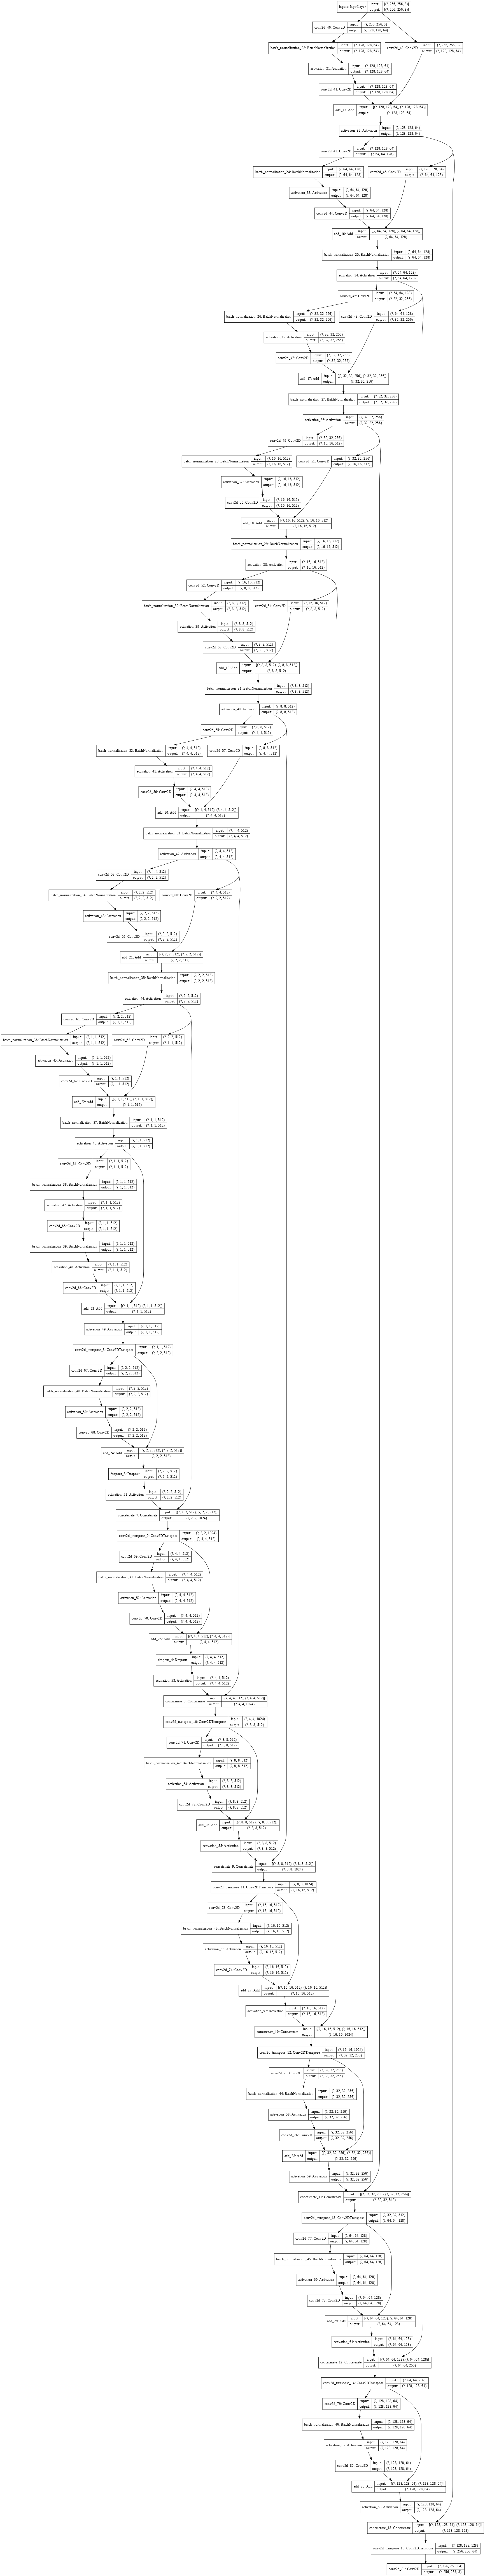

In [15]:
plot_model(model, to_file = 'unet.png', show_shapes=True, dpi=64)